In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import streamlit as st
import requests
import uvicorn
import shap

import pickle

from PIL import Image

In [2]:
# On importe le df enregistré précédemment contenant les features sélectionnées
# et les probabilités pour chaque client

df = pd.read_csv('data_prob.csv', sep=';')
df = df.drop("Unnamed: 0", axis=1)

# Tri des données dans l'ordre croissant pour l'identifiant
df = df.sort_values(by='SK_ID_CURR').reset_index(drop=True)

# Importation du fichier de données filtrées
df_filtered = pd.read_csv('df_filtered_p7.csv', sep=';', index_col='SK_ID_CURR')
df_filtered = df_filtered.drop('Unnamed: 0', axis=1)

data = df_filtered.copy().reset_index()

In [3]:
# On crée une fonction affichant la jauge de prédiction du seuil pour chaque client
def jauge(value, optimal_threshold):
    if value > optimal_threshold:
        color='red'
    else:
        color='green'
    fig = go.Figure(go.Indicator(
        domain = {'x': [0, 1], 'y': [0, 1]},
        value = value,
        mode = "gauge+number",
        title = {'text': f"Probabilité prédite (seuil optimal: {optimal_threshold})"},
        gauge = {'axis': {'range': [None, 1]}, 
                 'steps': [
                     {'range': [0, 0.5], 'color': "lightgray"},
                     {'range': [0.5, 1], 'color': "gray"}],
                 'threshold': {'line' : {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': optimal_threshold},
                 'bar' : {'color' : color}}))
    
    return fig

In [4]:
# On importe le fichier contenant les valeurs de shap
with open('shap_values.pickle', 'rb') as file:
    shap_file = pickle.load(file)

shap_values = shap_file['shap_values']
data_shap_scaled = shap_file['shap_scaled']
explainer = shap_file['explainer']
data_shap = shap_file['data_shap']

In [5]:
# On crée une fonction qui affiche 2 graphiques de la distribution d'une feature sélectionnée
# pour les 2 classes

def distri_features(df, optimal_threshold, feature, client_value):
    # Clients de la classe 1 (prêt non accordé) en utilisant le seuil
    class_1_data = df[df['Proba'] >= optimal_threshold]
    
    # Clients de la classe 0 (prêt accordé) en utilisant le seuil
    class_0_data = df[df['Proba'] < optimal_threshold]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Distribution de la feature pour la classe 0 (prêt accordé)
    sns.histplot(class_0_data[feature], kde=True, color='green', ax=axes[0])
    axes[0].axvline(client_value, color='blue', linestyle='dashed', linewidth=1)
    axes[0].set_title(f"Distribution de la feature {feature} pour la classe 0 (prêt accordé)")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Count')

    # Distribution de la feature pour la classe 1 (prêt non accordé)
    sns.histplot(class_1_data[feature], kde=True, color='red', ax=axes[1])
    axes[1].axvline(client_value, color='blue', linestyle='dashed', linewidth=1)
    axes[1].set_title(f"Distribution de la feature {feature} pour la classe 1 (prêt non accordé)")
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel('Count')
    
    plt.tight_layout()
    
    fig = plt.gcf()
    st.pyplot(fig)

In [6]:
# On crée une fonction affichant un nuage de points entre 2 features sélectionnées

def bivarié_plot(feature1, feature2, df, client_value):
    # Scores des clients
    score = df['Proba']
    
    # Données des deux fonctionnalités
    data_features = df[[feature1, feature2]]
    
    # Positions des clients
    client_positions = data_features.loc[client_value]
    
    # Scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(data_features[feature1], data_features[feature2], c=score, cmap='coolwarm')
    plt.colorbar(scatter, label='Scores')
    plt.scatter(client_positions[feature1], client_positions[feature2], color='black', marker='*', s=200, label='Client')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title('Analyse bi-variée entre {} et {} pour le client {}'.format(feature1, feature2, client_value))
    plt.legend(loc='upper right')
    
    fig = plt.gcf()
    st.pyplot(fig)

2023-07-06 10:53:57.238 
  command:

    streamlit run C:\Users\evaro\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


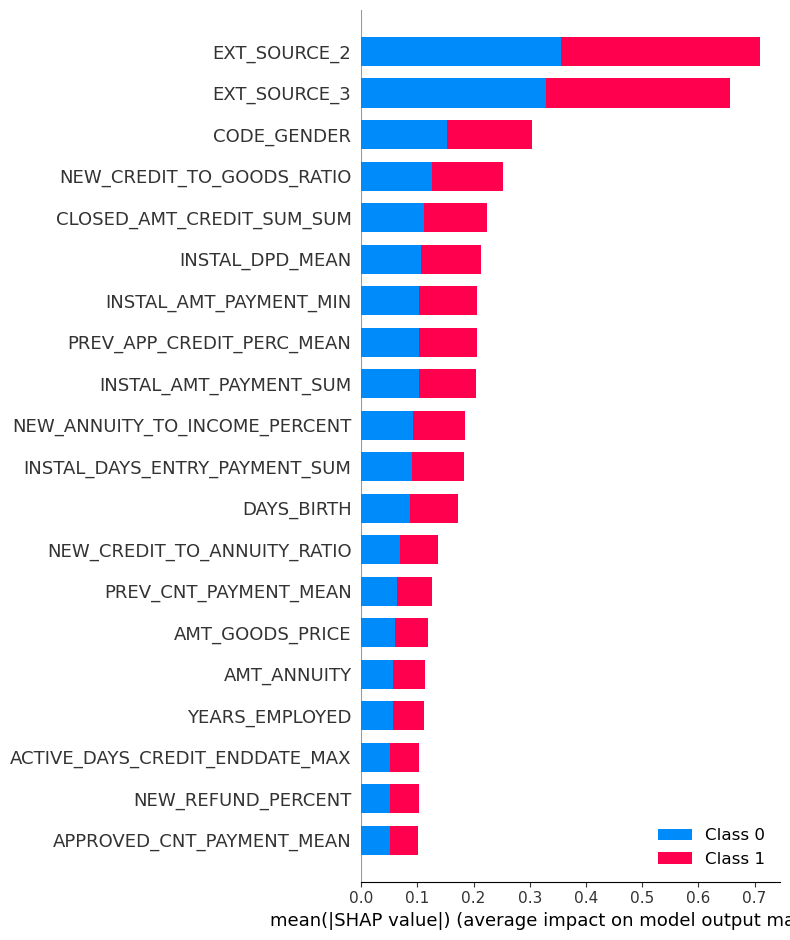

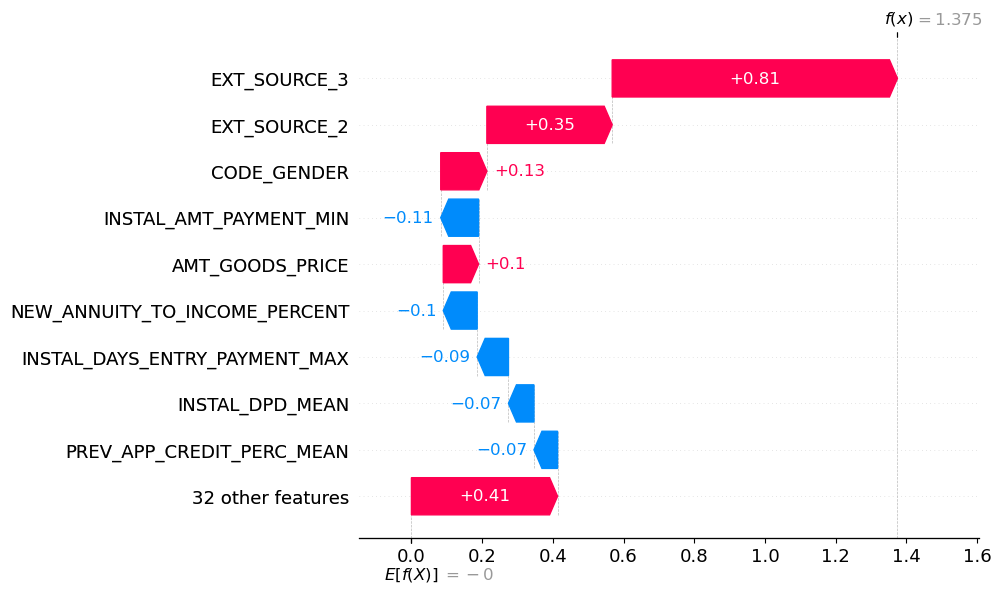

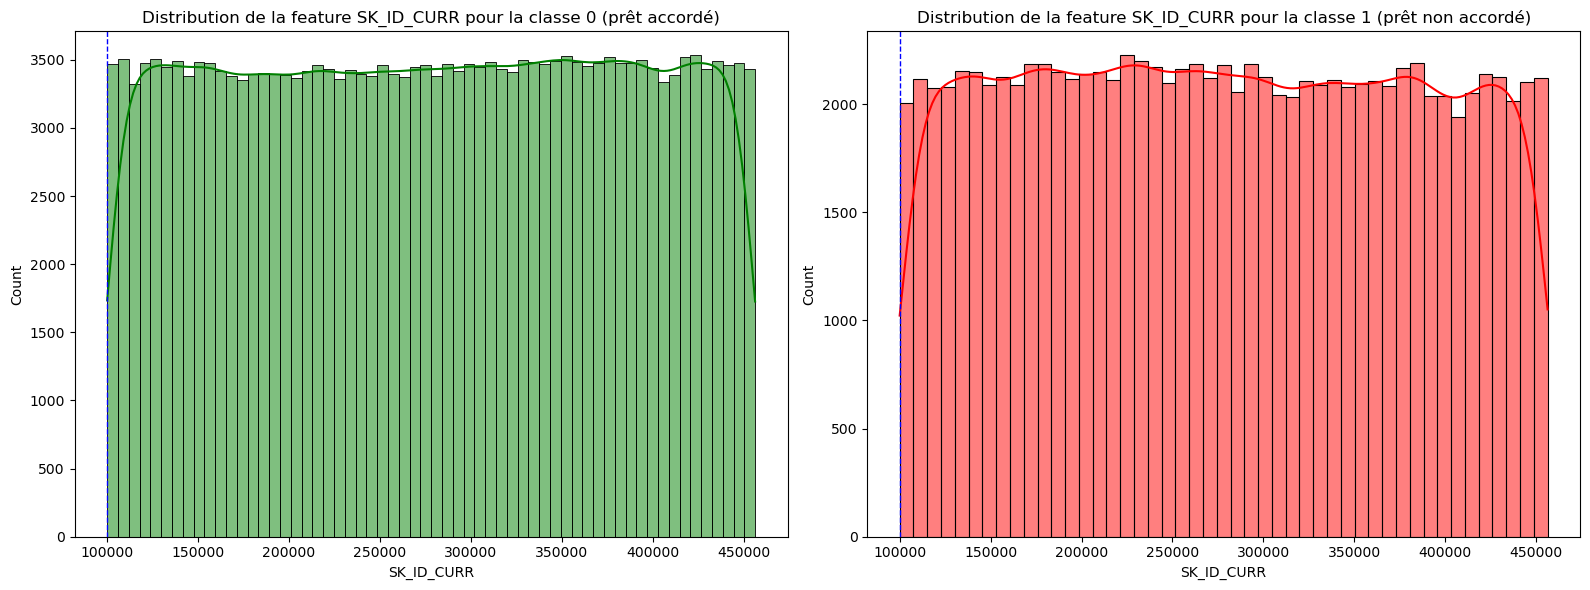

In [7]:
def get_client_info(client_id):
    response = requests.get(f"http://localhost:8001/clients/{client_id}")
    return response.json()

def get_threshold():
    response = requests.get("http://localhost:8001/threshold")
    return response.json()

# Créez une interface utilisateur Streamlit
def main():
    st.title("Application tableau de bord interactif")
    
    image = Image.open('image_P7.png')
    st.image(image, caption='Logo entreprise "prêt à dépenser"', use_column_width=True)
    
    # Appel de la fonction pour récupérer le seuil optimal
    optimal_threshold = get_threshold()['threshold']
    
    # Saisie de l'identifiant client
    client_id = st.selectbox("Sélectionnez l'identifiant client :", df['SK_ID_CURR'].unique())
    
    # Vérifiez si l'identifiant client est saisi
    if client_id:
        # Appel de la fonction pour récupérer les informations du client
        client_info = get_client_info(client_id)
        
        # Vérifiez si le client est trouvé
        if "message" in client_info:
            st.error("Client non trouvé")
        else:
            # Affichage des informations du client
            st.subheader("Informations du client")
            
            # Formatage des informations en texte
            info_text = ""
            for key, value in client_info.items():
                info_text += f"{key} {value}\n"
            
            # Affichage des informations formatées
            st.text(info_text)
            
            # Récupération du score du client
            score = client_info.get("Score du client:")
                
            # Comparaison de la probabilité prédite avec le seuil optimal
            if score > optimal_threshold:
                position = "Refusé"
                position_color = "red"
            else:
                position = "Accepté"
                position_color = "green"
                    
            # Affichage de la jauge
            fig = jauge(score, optimal_threshold)
            fig.update_layout(annotations=[
                dict(
                    x=0.5,
                    y=0.45,
                    text=position,
                    showarrow=False,
                    font=dict(color=position_color, size=24)
                )
            ])
            st.plotly_chart(fig)
            
            st.subheader(f"Feature importance globale (à gauche) et locale du client {client_id} (à droite)")
            
            # Feature importance globale
            fig, ax = plt.subplots()
            summary_plot = shap.summary_plot(shap_values, data_shap_scaled, feature_names=data_shap.columns, show=False)
            columns = st.columns(2)

            with columns[0]:
                st.pyplot(fig)

            # Feature importance locale
            client_data_shap = data_shap[data_shap['SK_ID_CURR'] == int(client_id)].index.item()
            explanation_client = shap.Explanation(values=shap_values[1][client_data_shap], base_values=explainer.expected_value[1], feature_names=data_shap.columns)

            # Création du waterfall plot pour le client spécifié
            fig2, ax2 = plt.subplots()
            waterfall_plot = shap.plots.waterfall(explanation_client, show=False)
            with columns[1]:
                st.pyplot(fig2)
            
            st.subheader("Distribution de la feature sélectionnée dans la liste")

            # Sélection d'une feature pour le graphique de distribution
            feature = st.selectbox("Sélectionnez une feature:", df.columns)

            # Récupération de la valeur de la feature pour le client sélectionné
            client_data = df[df['SK_ID_CURR'] == int(client_id)]
            if not client_data.empty:
                client_value = client_data[feature].values[0]
                # Affichage des graphiques de distribution
                distri_features(df, optimal_threshold, feature, client_value)
            else:
                st.warning("Aucune donnée disponible pour cet identifiant client")
            
            st.subheader("Analyse bi-variée entre 2 features sélectionnées (dégradé de couleur selon le score)")
            
            # Sélection de 2 features
            selected_features = st.multiselect("Sélectionnez deux features:", df.columns, default=[])
            
            # Vérification
            if len(selected_features) != 2:
                st.warning("Veuillez sélectionner exactement deux features.")
            else:
                feature1, feature2 = selected_features[0], selected_features[1]
                # Affichage scatter plot
                if not client_data.empty:
                    bivarié_plot(feature1, feature2, df, int(client_id))
                else:
                    st.warning("Aucune donnée disponible pour cet identifiant client")
            
# Exécution de l'application Streamlit
if __name__ == "__main__":
    main()